# Import Library

In [1]:
# Import library
import joblib
import pandas as pd
import numpy as np
from collections import Counter

# Feature Engineering
from sklearn.feature_extraction.text import TfidfVectorizer

# Data Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from imblearn.under_sampling import RandomUnderSampler

# Model & Evaluation Metrics
from xgboost import XGBClassifier

from sklearn.model_selection import cross_val_score, RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import roc_curve, auc,roc_auc_score
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt


# Load File

In [2]:
# Load File -----------------------------------------------------------------------------------------------------------------------------------
file_path = r"..\Pre_Hate_Dataset\20_Hate_Final.csv"
df = pd.read_csv(file_path)

# TF-IDF Vectorization （Feature Engineering）---------------------------------------------------------------------------------------------------
tfidf = TfidfVectorizer(max_features=10000)
textData = tfidf.fit_transform(df['text'])

x = textData
y = df['label']
label_encoder = LabelEncoder() # Encode target labels into numeric values
y = label_encoder.fit_transform(y)

# Train Test Split -------------------------------------------------------------------------------------------------------------------------------
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)
print("Train distribution:", Counter(y_train))
print("Validation distribution:", Counter(y_test))

# Resampling --------------------------------------------------------------------------------------------------------------------------------------
print("Class distribution before resampling:", Counter(y_train))
undersampler = RandomUnderSampler(random_state=42)

x_train_resampled, y_train_resampled = undersampler.fit_resample(x_train, y_train)
print("Class distribution after resampling:", Counter(y_train_resampled))


Train distribution: Counter({0: 39404, 1: 18043})
Validation distribution: Counter({0: 16860, 1: 7761})
Class distribution before resampling: Counter({0: 39404, 1: 18043})
Class distribution after resampling: Counter({0: 18043, 1: 18043})


# Oversampling - SMOTE

In [ ]:
from imblearn.over_sampling import SMOTE
from collections import Counter

smote = SMOTE(random_state=42)
x_train_resampled, y_train_resampled = smote.fit_resample(x_train, y_train)

print("Class distribution after resampling:", Counter(y_train_resampled))


# XGB (by default)

[0]	validation_0-logloss:0.66047	validation_1-logloss:0.66609
[1]	validation_0-logloss:0.64224	validation_1-logloss:0.65151
[2]	validation_0-logloss:0.62889	validation_1-logloss:0.64193
[3]	validation_0-logloss:0.61925	validation_1-logloss:0.63691
[4]	validation_0-logloss:0.61106	validation_1-logloss:0.63004
[5]	validation_0-logloss:0.60431	validation_1-logloss:0.62659
[6]	validation_0-logloss:0.59877	validation_1-logloss:0.62474
[7]	validation_0-logloss:0.59191	validation_1-logloss:0.62049
[8]	validation_0-logloss:0.58690	validation_1-logloss:0.61803
[9]	validation_0-logloss:0.58240	validation_1-logloss:0.61428
[10]	validation_0-logloss:0.57824	validation_1-logloss:0.61134
[11]	validation_0-logloss:0.57502	validation_1-logloss:0.61030
[12]	validation_0-logloss:0.57152	validation_1-logloss:0.60849
[13]	validation_0-logloss:0.56820	validation_1-logloss:0.60677
[14]	validation_0-logloss:0.56547	validation_1-logloss:0.60534
[15]	validation_0-logloss:0.56289	validation_1-logloss:0.60369
[1

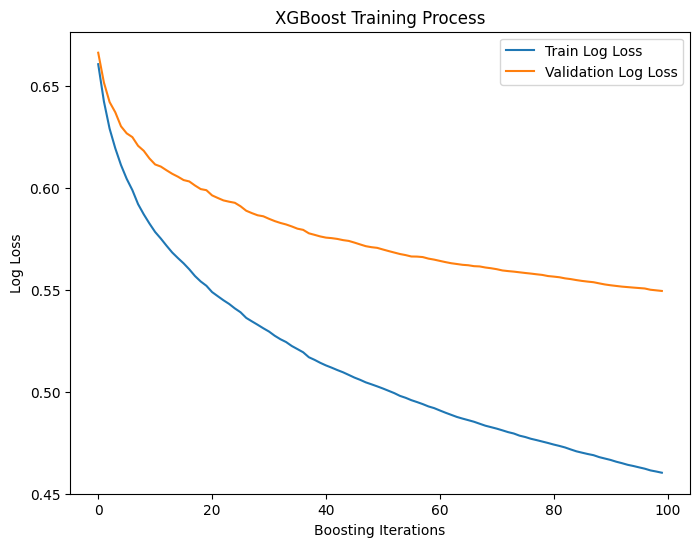

Training completed and model saved.

📌 Train Accuracy: 0.8006
📌 Test Accuracy: 0.7821

📌 Weighted F1 Score: 0.7855
📌 Micro F1 Score: 0.7821
📌 Macro F1 Score: 0.7560

📌 Precision: 0.6362
📌 Recall: 0.7214

📌 Test ROC AUC: 0.8394
Cross-validation F1 score: [0.75335934 0.74762253 0.74686498 0.74795322 0.75040117]
Average F1 Score: 0.7492402461685435

📌 Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.81      0.84     16860
           1       0.64      0.72      0.68      7761

    accuracy                           0.78     24621
   macro avg       0.75      0.77      0.76     24621
weighted avg       0.79      0.78      0.79     24621


📌 Confusion Matrix:
[[13658  3202]
 [ 2162  5599]]


In [4]:
xgb_default = XGBClassifier(
    objective='binary:logistic', 
    eval_metric='logloss',  
    random_state=42
)
eval_set = [(x_train_resampled, y_train_resampled), (x_test, y_test)]  
xgb_default.fit(x_train_resampled, y_train_resampled, 
        eval_set=eval_set, 
        verbose=True, )

results = xgb_default.evals_result()

epochs = len(results['validation_0']['logloss']) 
x_axis = range(epochs)

plt.figure(figsize=(8, 6))
plt.plot(x_axis, results['validation_0']['logloss'], label='Train Log Loss')
plt.plot(x_axis, results['validation_1']['logloss'], label='Validation Log Loss')
plt.xlabel("Boosting Iterations")
plt.ylabel("Log Loss")
plt.title("XGBoost Training Process")
plt.legend()
plt.show()

# Save Model
joblib.dump(xgb_default, "XGB_Default_Model.pkl")
print("Training completed and model saved.")

# Evaluate Model ---------------------------------------------------------------------------------------------------------------------

y_train_pred = xgb_default.predict(x_train_resampled)
y_test_pred = xgb_default.predict(x_test)

y_train_pred_prob = xgb_default.predict_proba(x_train_resampled)[:, 1]
y_test_pred_prob = xgb_default.predict_proba(x_test)[:, 1]

train_accuracy = accuracy_score(y_train_resampled, y_train_pred)
print(f"\n📌 Train Accuracy: {train_accuracy:.4f}")

test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"📌 Test Accuracy: {test_accuracy:.4f}")

f1_weighted = f1_score(y_test, y_test_pred, average='weighted')
print(f"\n📌 Weighted F1 Score: {f1_weighted:.4f}")

f1_micro = f1_score(y_test, y_test_pred, average='micro')
print(f"📌 Micro F1 Score: {f1_micro:.4f}")

f1_macro = f1_score(y_test, y_test_pred, average='macro')
print(f"📌 Macro F1 Score: {f1_macro:.4f}")

precision = precision_score(y_test, y_test_pred, average='binary') 
print(f"\n📌 Precision: {precision:.4f}")

recall = recall_score(y_test, y_test_pred, average='binary')
print(f"📌 Recall: {recall:.4f}")

fpr, tpr, thresholds = roc_curve(y_test, y_test_pred_prob)
roc_auc = auc(fpr, tpr)
print(f"\n📌 Test ROC AUC: {roc_auc:.4f}")

scores = cross_val_score(xgb_default, x_train_resampled, y_train_resampled, cv=5, scoring='f1')
print("Cross-validation F1 score:", scores)
print("Average F1 Score:", scores.mean())

print("\n📌 Classification Report:")
print(classification_report(y_test, y_test_pred))

print("\n📌 Confusion Matrix:")
print(confusion_matrix(y_test, y_test_pred))

## Loss Curve

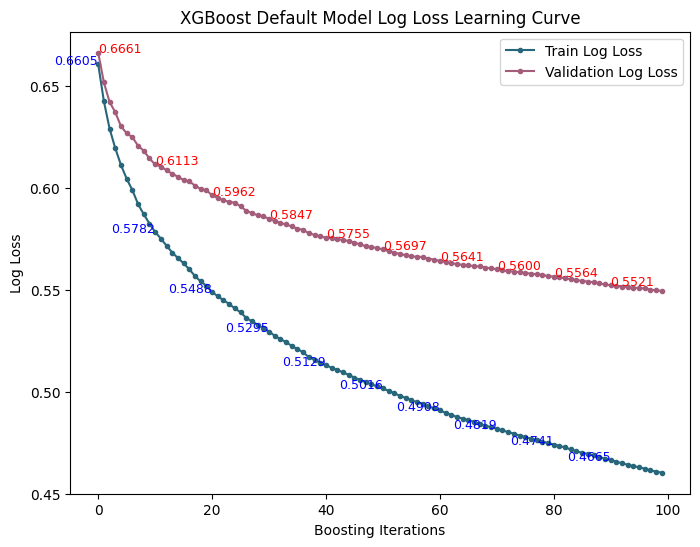

In [17]:
import matplotlib.pyplot as plt

epochs = len(results['validation_0']['logloss'])  
x_axis = range(epochs)

plt.figure(figsize=(8, 6))
plt.plot(x_axis, results['validation_0']['logloss'], label='Train Log Loss', marker='.',color='#27667B')
plt.plot(x_axis, results['validation_1']['logloss'], label='Validation Log Loss', marker='.',color='#A35C7A')

for i in range(0, epochs, max(1, epochs // 10)):
    plt.text(x_axis[i], results['validation_0']['logloss'][i], f"{results['validation_0']['logloss'][i]:.4f}", 
             fontsize=9, ha='right', color='blue')
    plt.text(x_axis[i], results['validation_1']['logloss'][i], f"{results['validation_1']['logloss'][i]:.4f}", 
             fontsize=9, ha='left', color='red')

plt.xlabel("Boosting Iterations")
plt.ylabel("Log Loss")
plt.title("XGBoost Default Model Log Loss Learning Curve")
plt.legend()
plt.show()


## Confusion Matrix

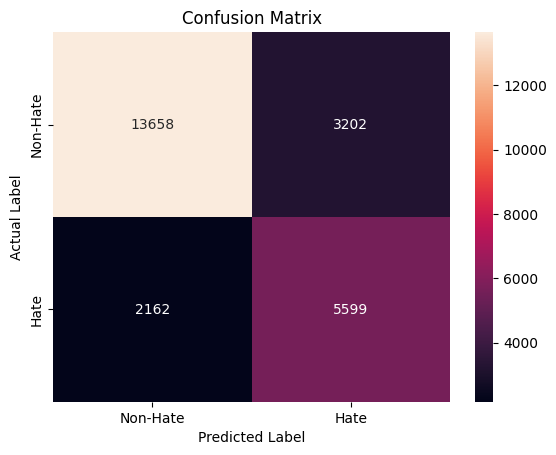

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_test_pred)

sns.heatmap(cm, annot=True, fmt="d", 
            xticklabels=['Non-Hate', 'Hate'], 
            yticklabels=['Non-Hate', 'Hate'])


plt.xlabel("Predicted Label") 
plt.ylabel("Actual Label")  
plt.title("Confusion Matrix") 
plt.show()



## Learning Curve (Base model)

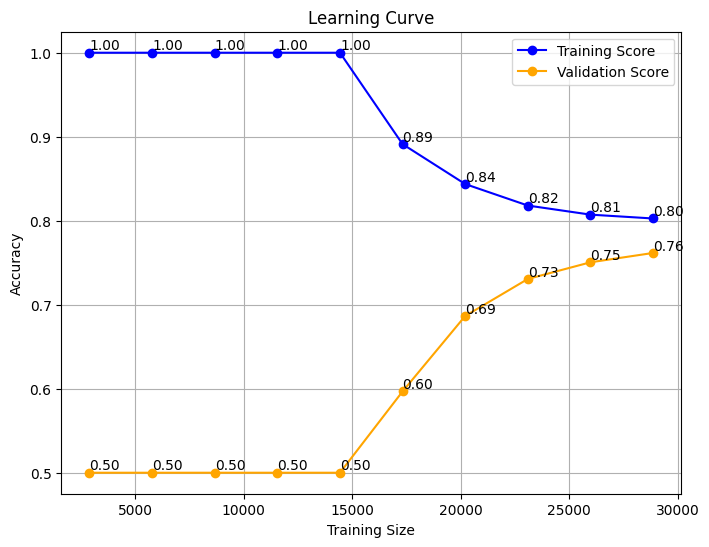

In [ ]:
train_sizes, train_scores, test_scores = learning_curve(
    xgb_default, x_train_resampled, y_train_resampled, cv=5, scoring='accuracy', train_sizes=np.linspace(0.1, 1.0, 10)
)

train_scores_mean = train_scores.mean(axis=1)
test_scores_mean = test_scores.mean(axis=1)

plt.figure(figsize=(8, 6))

plt.plot(train_sizes, train_scores_mean, label='Training Score', color='blue', marker='o')

for i, txt in enumerate(train_scores_mean):
    plt.text(train_sizes[i], train_scores_mean[i], f"{txt:.2f}", fontsize=10, verticalalignment='bottom')

plt.plot(train_sizes, test_scores_mean, label='Validation Score', color='orange', marker='o')

for i, txt in enumerate(test_scores_mean):
    plt.text(train_sizes[i], test_scores_mean[i], f"{txt:.2f}", fontsize=10, verticalalignment='bottom')

plt.title('Learning Curve')
plt.xlabel('Training Size')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


## precision_recall_curve


📌 Precision-Recall AUC: 0.5468


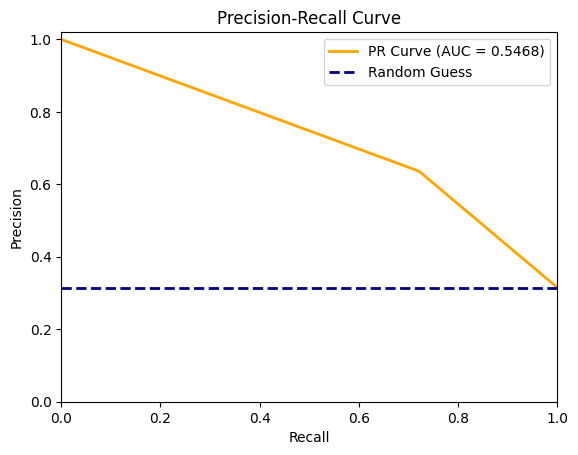

In [ ]:
precision, recall, _ = precision_recall_curve(y_test, y_test_pred)
pr_auc = average_precision_score(y_test, y_test_pred)

print(f"\n📌 Precision-Recall AUC: {pr_auc:.4f}")

plt.figure()
plt.plot(recall, precision, color='orange', lw=2, label=f'PR Curve (AUC = {pr_auc:.4f})')

baseline = sum(y_test) / len(y_test)  
plt.plot([0, 1], [baseline, baseline], color='navy', lw=2, linestyle='--', label='Random Guess')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.02])

plt.xlabel('Recall')
plt.ylabel('Precision')

plt.title('Precision-Recall Curve')
plt.legend(loc="upper right")
plt.show()


## ROC-AUC (Base Model)

Train ROC AUC: 0.8701
Test ROC AUC: 0.8394


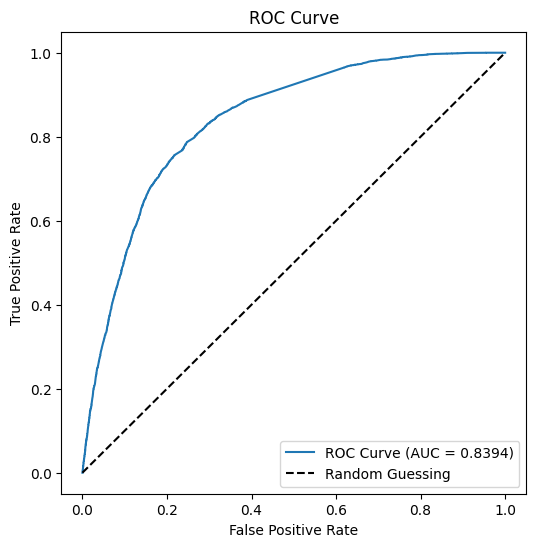

In [ ]:
y_train_probs = xgb_default.predict_proba(x_train)[:, 1]  # Probability for class 1: Hate
y_test_probs = xgb_default.predict_proba(x_test)[:, 1]

train_auc = roc_auc_score(y_train, y_train_probs)
test_auc = roc_auc_score(y_test, y_test_probs)
print(f"Train ROC AUC: {train_auc:.4f}")
print(f"Test ROC AUC: {test_auc:.4f}")

fpr, tpr, _ = roc_curve(y_test, y_test_probs)
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {test_auc:.4f})')
plt.plot([0,1], [0,1], 'k--', label="Random Guessing")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()


# Random Search For XGBoost Model

In [ ]:
# HP base on: https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/
param_grid = {
    'reg_lambda': [5, 10, 15, 20],
    'reg_alpha': [3, 5, 10],
    'n_estimators': [50, 100, 150, 200],
    'max_depth': [8, 10, 15, 20],
    'learning_rate': [0.1, 0.2, 0.3],
    'gamma': [0, 0.1, 0.2, 0.3], 
    'subsample': [0.5, 0.7, 0.8, 1.0],  
    'colsample_bytree': [0.5, 0.7, 0.8, 1.0], 
    'min_child_weight': [1, 3, 5, 7] 
}

xgb = XGBClassifier(
    objective='binary:logistic',  
    eval_metric='logloss',
)

XGBoost_random_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_grid, 
    scoring='f1_weighted',  
    cv=5,  
    verbose=True,
    random_state=42,
    n_iter=10, 
)

print("Training completed and results saved.")
print("Best parameters found: ", XGBoost_random_search.best_params_)
print("Best f1_weighted score: ", XGBoost_random_search.best_score_)


# Save model --------------------------------------------------------------------------------------------------------------- 

best_model_XGBoost = XGBoost_random_search.best_estimator_
joblib.dump(best_model_XGBoost, "1_XGB_HP_best_estimator_.pkl")

# Evaluate Model ---------------------------------------------------------------------------------------------------------------------

y_train_pred = best_model_XGBoost.predict(x_train_resampled)
y_test_pred = best_model_XGBoost.predict(x_test)

y_train_pred_prob = best_model_XGBoost.predict_proba(x_train_resampled)[:, 1]
y_test_pred_prob = best_model_XGBoost.predict_proba(x_test)[:, 1]

train_accuracy = accuracy_score(y_train_resampled, y_train_pred)
print(f"\n📌 Train Accuracy: {train_accuracy:.4f}")

test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"📌 Validation Accuracy: {test_accuracy:.4f}")

f1_weighted = f1_score(y_test, y_test_pred, average='weighted')
print(f"\n📌 Weighted F1 Score: {f1_weighted:.4f}")

f1_micro = f1_score(y_test, y_test_pred, average='micro')
print(f"📌 Micro F1 Score: {f1_micro:.4f}")

f1_macro = f1_score(y_test, y_test_pred, average='macro')
print(f"📌 Macro F1 Score: {f1_macro:.4f}")

precision = precision_score(y_test, y_test_pred, average='binary') 
print(f"\n📌 Precision: {precision:.4f}")

recall = recall_score(y_test, y_test_pred, average='binary')
print(f"📌 Recall: {recall:.4f}")

fpr, tpr, thresholds = roc_curve(y_test, y_test_pred_prob)
roc_auc = auc(fpr, tpr)
print(f"\n📌 ROC AUC: {roc_auc:.4f}")

scores = cross_val_score(best_model_XGBoost, x_train_resampled, y_train_resampled, cv=5, scoring='f1')
print("Cross-validation F1 score:", scores)
print("Average F1 Score:", scores.mean())

print("\n📌 Classification Report:")
print(classification_report(y_test, y_test_pred))

print("\n📌 Confusion Matrix:")
print(confusion_matrix(y_test, y_test_pred))


Fitting 5 folds for each of 10 candidates, totalling 50 fits
Training completed and results saved.
Best parameters found:  {'subsample': 0.8, 'reg_lambda': 10, 'reg_alpha': 5, 'n_estimators': 200, 'min_child_weight': 3, 'max_depth': 20, 'learning_rate': 0.3, 'gamma': 0.1, 'colsample_bytree': 0.7}
Best f1_weighted score:  0.751043052525276

📌 Train Accuracy: 0.8460
📌 Test Accuracy: 0.7646

📌 Weighted F1 Score: 0.7704
📌 Micro F1 Score: 0.7646
📌 Macro F1 Score: 0.7427

📌 Precision: 0.6014
📌 Recall: 0.7502

📌 Test ROC AUC: 0.8352
Cross-validation F1 score: [0.75854404 0.74309081 0.751693   0.73946252 0.74202241]
Average F1 Score: 0.7469625549320855

📌 Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.77      0.82     16860
           1       0.60      0.75      0.67      7761

    accuracy                           0.76     24621
   macro avg       0.74      0.76      0.74     24621
weighted avg       0.79      0.76      0.77     2

### Confusion Matrix

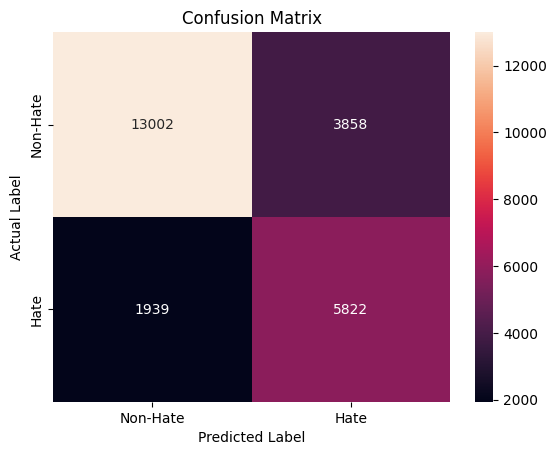

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_test_pred)

sns.heatmap(cm, annot=True, fmt="d", 
            xticklabels=['Non-Hate', 'Hate'], 
            yticklabels=['Non-Hate', 'Hate'])


plt.xlabel("Predicted Label") 
plt.ylabel("Actual Label")  
plt.title("Confusion Matrix") 
plt.show()



## ROC-AUC Score

Train ROC AUC: 0.9233
Test ROC AUC: 0.8352


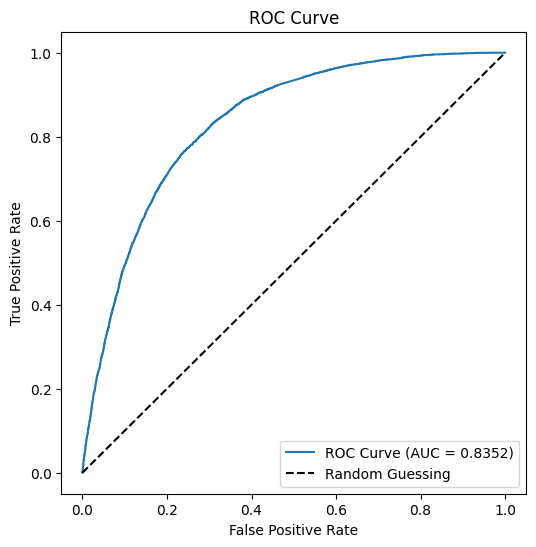

In [ ]:
y_train_probs = best_model_XGBoost.predict_proba(x_train_resampled)[:, 1]
y_test_probs = best_model_XGBoost.predict_proba(x_test)[:, 1]

train_auc = roc_auc_score(y_train_resampled, y_train_probs)
test_auc = roc_auc_score(y_test, y_test_probs)
print(f"Train ROC AUC: {train_auc:.4f}")
print(f"Test ROC AUC: {test_auc:.4f}")

fpr, tpr, _ = roc_curve(y_test, y_test_probs)
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {test_auc:.4f})')
plt.plot([0,1], [0,1], 'k--', label="Random Guessing")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()


## precision_recall_curve


📌 Precision-Recall AUC: 0.5299


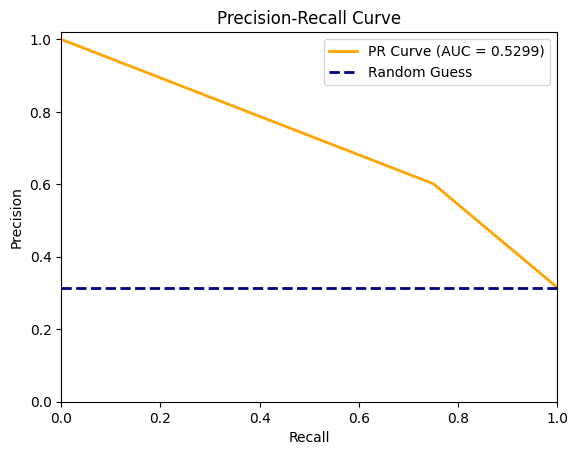

In [ ]:
precision, recall, _ = precision_recall_curve(y_test, y_test_pred)
pr_auc = average_precision_score(y_test, y_test_pred)

print(f"\n📌 Precision-Recall AUC: {pr_auc:.4f}")

plt.figure()
plt.plot(recall, precision, color='orange', lw=2, label=f'PR Curve (AUC = {pr_auc:.4f})')

baseline = sum(y_test) / len(y_test)  
plt.plot([0, 1], [baseline, baseline], color='navy', lw=2, linestyle='--', label='Random Guess')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.02])

plt.xlabel('Recall')
plt.ylabel('Precision')

plt.title('Precision-Recall Curve')
plt.legend(loc="upper right")
plt.show()


## Learning Curve

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each

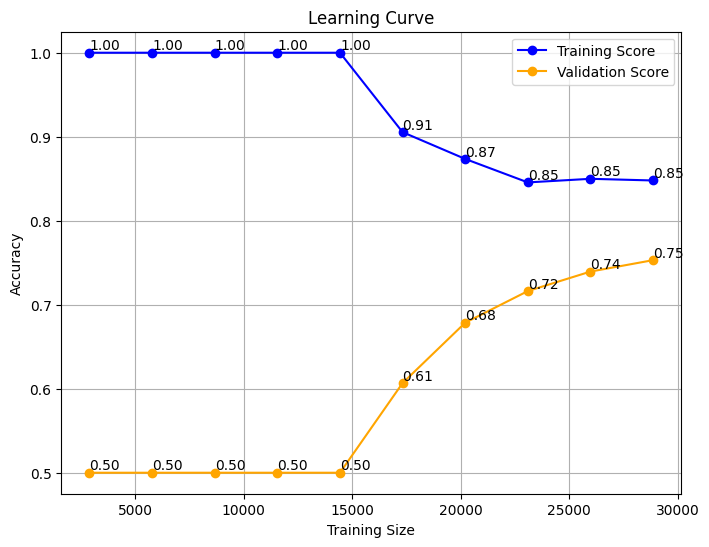

In [ ]:
import joblib

model = joblib.load(r"Saved Model Hate/XGB/1_XGB_HP.pkl") 

train_sizes, train_scores, test_scores = learning_curve(
    model, x_train_resampled, y_train_resampled, cv=5, scoring='accuracy', train_sizes=np.linspace(0.1, 1.0, 10)
)

train_scores_mean = train_scores.mean(axis=1)
test_scores_mean = test_scores.mean(axis=1)

plt.figure(figsize=(8, 6))

plt.plot(train_sizes, train_scores_mean, label='Training Score', color='blue', marker='o')

for i, txt in enumerate(train_scores_mean):
    plt.text(train_sizes[i], train_scores_mean[i], f"{txt:.2f}", fontsize=10, verticalalignment='bottom')

plt.plot(train_sizes, test_scores_mean, label='Validation Score', color='orange', marker='o')

for i, txt in enumerate(test_scores_mean):
    plt.text(train_sizes[i], test_scores_mean[i], f"{txt:.2f}", fontsize=10, verticalalignment='bottom')

plt.title('Learning Curve')
plt.xlabel('Training Size')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True) 
plt.show()


## Loss Curve

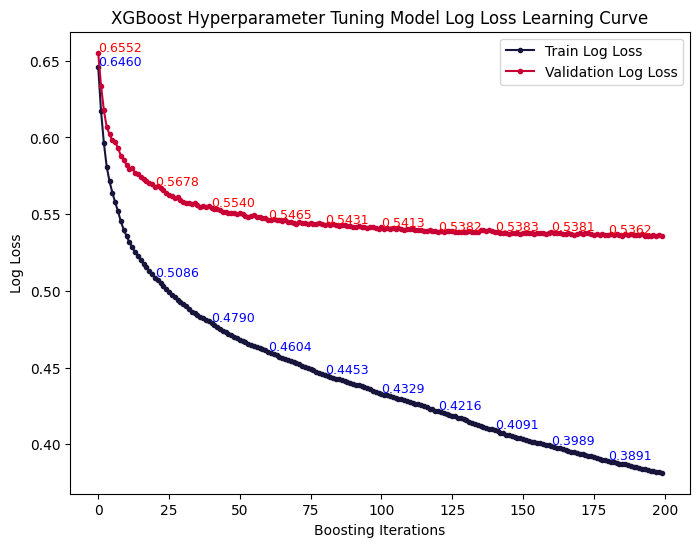

In [16]:
results = xgb.evals_result()

epochs = len(results['validation_0']['logloss'])  
x_axis = range(epochs)

plt.figure(figsize=(8, 6))
plt.plot(x_axis, results['validation_0']['logloss'], label='Train Log Loss', marker='.',color='#17153B')
plt.plot(x_axis, results['validation_1']['logloss'], label='Validation Log Loss', marker='.',color='#C80036')

for i in range(0, epochs, max(1, epochs // 10)):
    plt.text(x_axis[i], results['validation_0']['logloss'][i] + 0.001, 
             f"{results['validation_0']['logloss'][i]:.4f}", 
             fontsize=9, ha='left', color='blue')
    
    plt.text(x_axis[i], results['validation_1']['logloss'][i] + 0.001, 
             f"{results['validation_1']['logloss'][i]:.4f}", 
             fontsize=9, ha='left', color='red')


plt.xlabel("Boosting Iterations")
plt.ylabel("Log Loss")
plt.title("XGBoost Hyperparameter Tuning Model Log Loss Learning Curve")
plt.legend()
plt.show()

# Fine Tuning

In [ ]:
best_params = {
    'reg_lambda': 10,
    'reg_alpha': 1,
}

xgb_fine = XGBClassifier(
    objective='binary:logistic', 
    eval_metric='logloss',  
    random_state=42,
    **best_params
)
eval_set = [(x_train_resampled, y_train_resampled), (x_test, y_test)]  
xgb_fine.fit(x_train_resampled, y_train_resampled, 
        eval_set=eval_set, 
        verbose=True, )


[0]	validation_0-logloss:0.66173	validation_1-logloss:0.66633
[1]	validation_0-logloss:0.64383	validation_1-logloss:0.65176
[2]	validation_0-logloss:0.63119	validation_1-logloss:0.64252
[3]	validation_0-logloss:0.62211	validation_1-logloss:0.63722
[4]	validation_0-logloss:0.61466	validation_1-logloss:0.63110
[5]	validation_0-logloss:0.60664	validation_1-logloss:0.62378
[6]	validation_0-logloss:0.60094	validation_1-logloss:0.62178
[7]	validation_0-logloss:0.59614	validation_1-logloss:0.61932
[8]	validation_0-logloss:0.59123	validation_1-logloss:0.61671
[9]	validation_0-logloss:0.58727	validation_1-logloss:0.61373
[10]	validation_0-logloss:0.58376	validation_1-logloss:0.61227
[11]	validation_0-logloss:0.58095	validation_1-logloss:0.61102
[12]	validation_0-logloss:0.57773	validation_1-logloss:0.60767
[13]	validation_0-logloss:0.57511	validation_1-logloss:0.60581
[14]	validation_0-logloss:0.57272	validation_1-logloss:0.60596
[15]	validation_0-logloss:0.57005	validation_1-logloss:0.60376
[1

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)

In [11]:
joblib.dump(xgb_fine, "XGB_Fine_Model.pkl")
print("Training completed and model saved.")

Training completed and model saved.


## Evaluate Model

In [ ]:
# Evaluate Model ---------------------------------------------------------------------------------------------------------------------
y_train_pred = xgb_fine.predict(x_train_resampled)
y_test_pred = xgb_fine.predict(x_test)

y_train_pred_prob = xgb_fine.predict_proba(x_train_resampled)[:, 1]
y_test_pred_prob = xgb_fine.predict_proba(x_test)[:, 1]

train_accuracy = accuracy_score(y_train_resampled, y_train_pred)
print(f"\n📌 Train Accuracy: {train_accuracy:.4f}")

test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"📌 Test Accuracy: {test_accuracy:.4f}")

f1_weighted = f1_score(y_test, y_test_pred, average='weighted')
print(f"\n📌 Weighted F1 Score: {f1_weighted:.4f}")

f1_micro = f1_score(y_test, y_test_pred, average='micro')
print(f"📌 Micro F1 Score: {f1_micro:.4f}")

f1_macro = f1_score(y_test, y_test_pred, average='macro')
print(f"📌 Macro F1 Score: {f1_macro:.4f}")

precision = precision_score(y_test, y_test_pred, average='binary') 
print(f"\n📌 Precision: {precision:.4f}")

recall = recall_score(y_test, y_test_pred, average='binary')
print(f"📌 Recall: {recall:.4f}")

fpr, tpr, thresholds = roc_curve(y_test, y_test_pred_prob)
roc_auc = auc(fpr, tpr)
print(f"\n📌 Test ROC AUC: {roc_auc:.4f}")

print("\n📌 Classification Report:")
print(classification_report(y_test, y_test_pred))

print("\n📌 Confusion Matrix:")
print(confusion_matrix(y_test, y_test_pred))


📌 Train Accuracy: 0.7769
📌 Test Accuracy: 0.7717

📌 Weighted F1 Score: 0.7751
📌 Micro F1 Score: 0.7717
📌 Macro F1 Score: 0.7439

📌 Precision: 0.6222
📌 Recall: 0.7018

📌 Test ROC AUC: 0.8277

📌 Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.80      0.83     16860
           1       0.62      0.70      0.66      7761

    accuracy                           0.77     24621
   macro avg       0.74      0.75      0.74     24621
weighted avg       0.78      0.77      0.78     24621


📌 Confusion Matrix:
[[13553  3307]
 [ 2314  5447]]


## Loss Curve

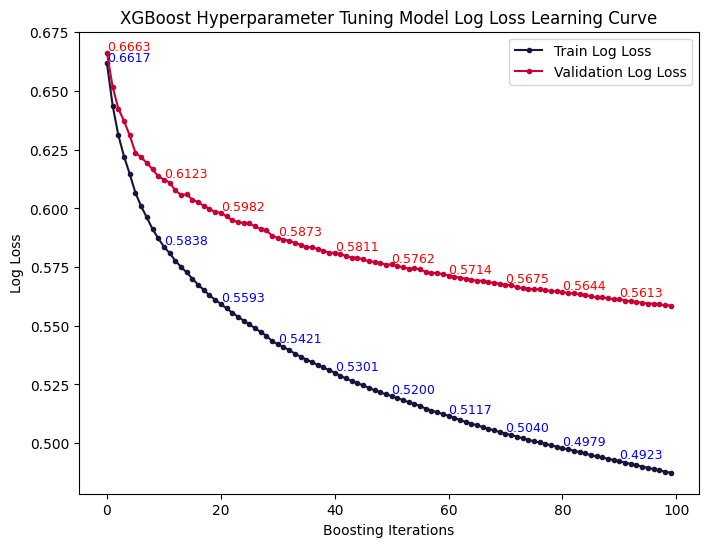

In [ ]:
results = xgb_fine.evals_result()

epochs = len(results['validation_0']['logloss'])  
x_axis = range(epochs)

plt.figure(figsize=(8, 6))
plt.plot(x_axis, results['validation_0']['logloss'], label='Train Log Loss', marker='.',color='#17153B')
plt.plot(x_axis, results['validation_1']['logloss'], label='Validation Log Loss', marker='.',color='#C80036')

for i in range(0, epochs, max(1, epochs // 10)):
    plt.text(x_axis[i], results['validation_0']['logloss'][i] + 0.001, 
             f"{results['validation_0']['logloss'][i]:.4f}", 
             fontsize=9, ha='left', color='blue')
    
    plt.text(x_axis[i], results['validation_1']['logloss'][i] + 0.001, 
             f"{results['validation_1']['logloss'][i]:.4f}", 
             fontsize=9, ha='left', color='red')

plt.xlabel("Boosting Iterations")
plt.ylabel("Log Loss")
plt.title("XGBoost Hyperparameter Tuning Model Log Loss Learning Curve")
plt.legend()
plt.show()

## Learning Curve

c:\Users\Asus\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
25 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Asus\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Asus\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py", line 729, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\Asus\AppData\Local\Programs\Python\Python312\Lib\site-packages\xg

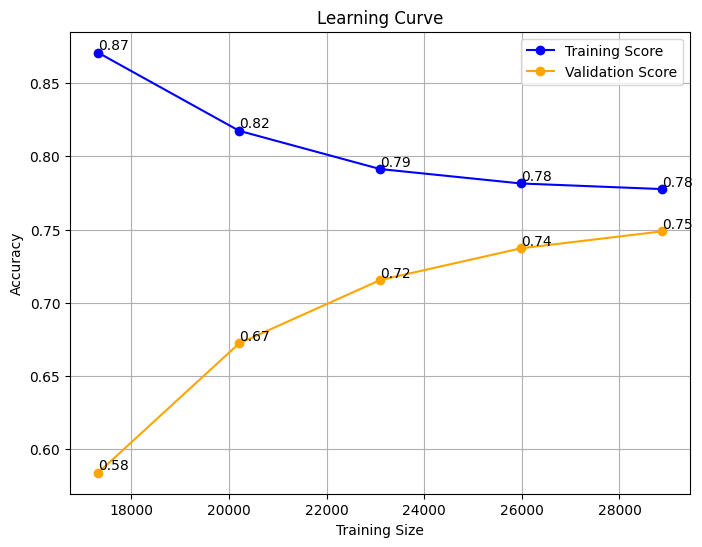

In [7]:
train_sizes, train_scores, test_scores = learning_curve(
    xgb_fine, x_train_resampled, y_train_resampled,  scoring='accuracy', train_sizes=np.linspace(0.1, 1.0, 10)
)

train_scores_mean = train_scores.mean(axis=1)
test_scores_mean = test_scores.mean(axis=1)

plt.figure(figsize=(8, 6))

plt.plot(train_sizes, train_scores_mean, label='Training Score', color='blue', marker='o')

for i, txt in enumerate(train_scores_mean):
    plt.text(train_sizes[i], train_scores_mean[i], f"{txt:.2f}", fontsize=10, verticalalignment='bottom')

plt.plot(train_sizes, test_scores_mean, label='Validation Score', color='orange', marker='o')

for i, txt in enumerate(test_scores_mean):
    plt.text(train_sizes[i], test_scores_mean[i], f"{txt:.2f}", fontsize=10, verticalalignment='bottom')

plt.title('Learning Curve')
plt.xlabel('Training Size')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True) 
plt.show()


## precision_recall_curve


📌 Precision-Recall AUC: 0.5307


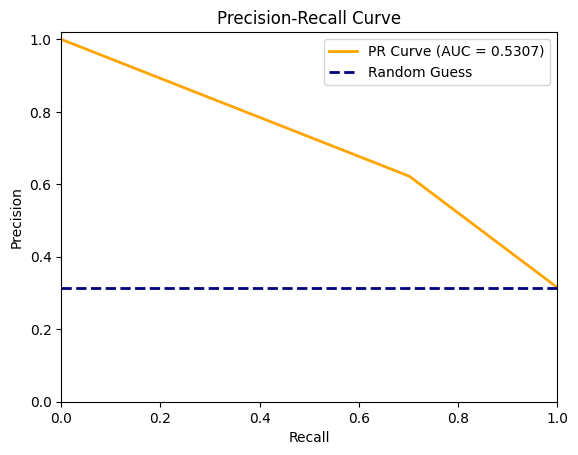

In [8]:
precision, recall, _ = precision_recall_curve(y_test, y_test_pred)
pr_auc = average_precision_score(y_test, y_test_pred)

print(f"\n📌 Precision-Recall AUC: {pr_auc:.4f}")

plt.figure()
plt.plot(recall, precision, color='orange', lw=2, label=f'PR Curve (AUC = {pr_auc:.4f})')

baseline = sum(y_test) / len(y_test)  
plt.plot([0, 1], [baseline, baseline], color='navy', lw=2, linestyle='--', label='Random Guess')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.02])

plt.xlabel('Recall')
plt.ylabel('Precision')

plt.title('Precision-Recall Curve')
plt.legend(loc="upper right")
plt.show()


## ROC-AUC Curve

Train ROC AUC: 0.8602
Test ROC AUC: 0.8277


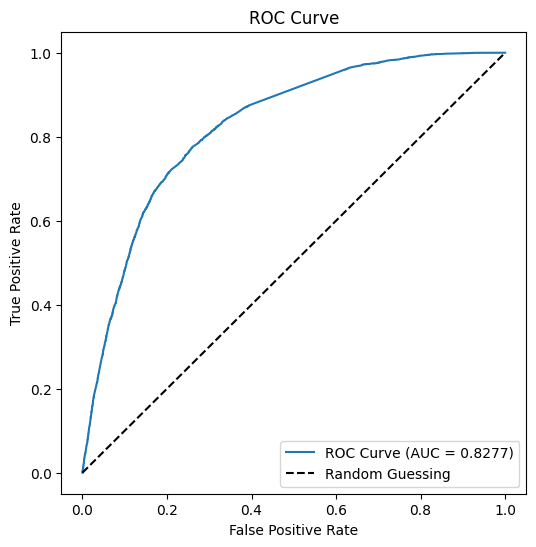

In [9]:
y_train_probs = xgb_fine.predict_proba(x_train_resampled)[:, 1]
y_test_probs = xgb_fine.predict_proba(x_test)[:, 1]

train_auc = roc_auc_score(y_train_resampled, y_train_probs)
test_auc = roc_auc_score(y_test, y_test_probs)
print(f"Train ROC AUC: {train_auc:.4f}")
print(f"Test ROC AUC: {test_auc:.4f}")

fpr, tpr, _ = roc_curve(y_test, y_test_probs)
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {test_auc:.4f})')
plt.plot([0,1], [0,1], 'k--', label="Random Guessing")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()


## Confusion Matrix

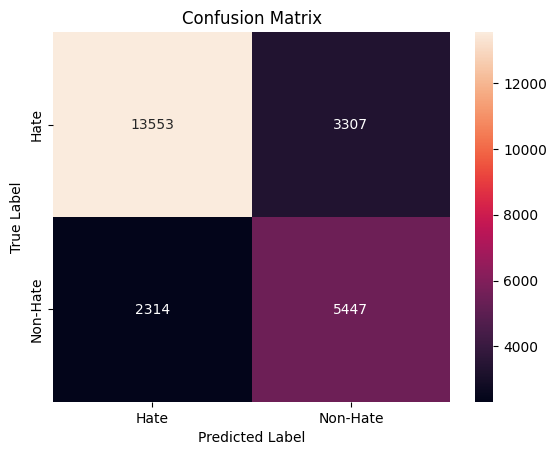

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_test_pred)

sns.heatmap(cm, annot=True, fmt="d", 
            xticklabels=['Hate', 'Non-Hate'], 
            yticklabels=['Hate', 'Non-Hate'])

plt.xlabel("Predicted Label") 
plt.ylabel("True Label")  
plt.title("Confusion Matrix") 
plt.show()

